# Tutorial on Gaussian Processes - Part Two

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

%matplotlib inline

Recap from last week's tutorial on sampling functions from a GP prior:

//anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


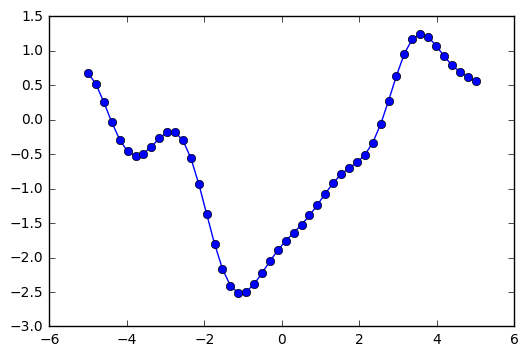

In [164]:
# code to sample from a GP

# define squared exponential kernel
def squared_exp_kernel(x1, x2, w=1, sigma=1):
    return (sigma ** 2) * np.exp(-1 * np.square(x1 - x2) / (2 * (w ** 2)))

# create a covariance matrix with two input vectors x1 and x2
def cov_matrix(x1, x2, w=1, sigma=1):
    K = np.empty([len(x1), len(x2)]) # initialize empty covariance matrix
    
    # loop over each entry in the matrix and evaluate 
    # each pair of data points with the kernel function
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i, j] = squared_exp_kernel(x1[i], x2[j], w, sigma)
        
    # return the filled in covariance matrix
    return K

# sample function from a GP
def GP(x, w=1, sigma=1):
    mean = np.zeros(len(x)) # create zero mean vector
    cov = cov_matrix(x, x, w, sigma) # create covariance matrix with squared exp kernel
    y = multivariate_normal.rvs(mean = mean, cov = cov) # sample from a GP
    return y

# sample functions from a GP
x = np.linspace(-5, 5, 50) # input vector
y = GP(x)

# plot functions
plt.plot(x, y, '-o')

So far, we've looked at how one might sample functions from a GP prior. However, what we're really interested in is sampling from the posterior of a GP *after* observing some data points. For example, in the figure below, suppose we've observed at the points $x$ takes on the values given by $f$ shown by the two blue points, how can we sample from the set of functions that incorporate knowledge of the observed data? In this plot, how can we sample test values $f^*$ at each of the test points $x^*$ shown in red?

(-1, 1)

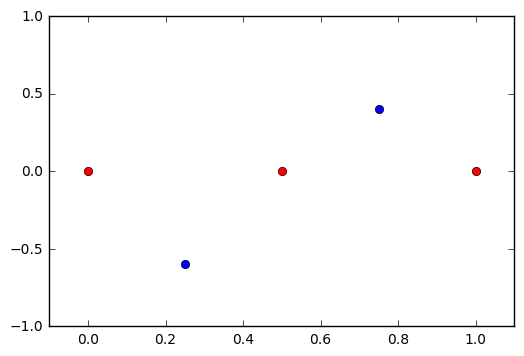

In [165]:
# observed points
x = np.array([0.25, 0.75])
y = np.array([-0.6, 0.4])

# new points
x_new = np.linspace(0, 1, 3)

# plot of both observed and new points
plt.plot(x, y, 'o')
plt.plot(x_new, np.zeros(len(x_new)), 'ro')
plt.xlim(-.1, 1.1)
plt.ylim(-1, 1)

## Sampling from a joint distribution of observed and test points

First, by the definition of a GP we know that the existing observed data points $f$ and the new points $f^*$ form a multivariate Gaussian distribution, and the joint distribution of $f$ and $f^*$ is given by:

$$ \begin{bmatrix}
f \\
f_*
\end{bmatrix}
\sim 
\mathcal{N}\big(\mathbf{0}, 
\begin{bmatrix}
    K(X, X) & K(X, X_*) \\
    K(X_*, X) & K(X_*, X_*)
 \end{bmatrix}\big)
$$

This creates a new GP prior which generates samples from both the locations of the observed data points $x$ and the locations of the new test points $x^*$. In particular, the covariance matrix is constructed by combining four smaller covariance matrices. For example, if there are $n$ training points and $n_*$ test points, then $K(X, X_*)$ is an $n \times n_*$ matrix of the covariances evaluated between each pair of training and test points. A similar logic applies for each of the other covariance matrices $K(X, X)$, $K(X_*, X)$ and $K(X_*, X_*)$.

(-0.1, 1.1)

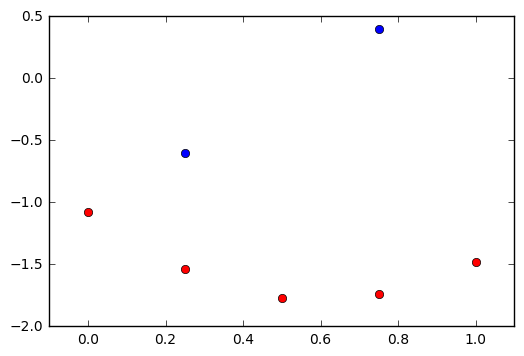

In [166]:
# function to calculate joint covariance matrix by combining four smaller covariance matrices
def joint_cov_matrix(x, x_new):
    k_X_X = cov_matrix(x, x)
    k_X_X_new = cov_matrix(x, x_new)
    k_X_new_X = cov_matrix(x_new, x)
    k_X_new_X_new = cov_matrix(x_new, x_new)
    
    k = np.vstack([
        np.hstack([k_X_X, k_X_X_new]),
        np.hstack([k_X_new_X, k_X_new_X_new])
    ])
    
    return k

# function to sample from a joint GP
def joint_GP(x, x_new, y):
    joint_mean = np.zeros(len(x) + len(x_new))
    joint_cov = joint_cov_matrix(x, x_new)
    y_new = multivariate_normal.rvs(mean = joint_mean, cov = joint_cov)
    return y_new

# sample functions from the joint distribution of a GP
y_new = joint_GP(x, x_new, y)

plt.plot(x, y, 'o')
plt.plot(np.concatenate([x, x_new]), y_new, 'ro')
plt.xlim(-.1, 1.1)


The red points show samples from the joint distribution of $\begin{bmatrix} f & f_* \end{bmatrix}$. However, one thing that is clear is that the samples at the location of the training points $x$ do not match the actual observed points $f$. 

## Sampling functions from the conditional distribution

How can we sample functions that pass through the observed data points? One possibility is to keep sampling from the joint distribution until we find that the sampled points are close enough to the observations (i.e. rejection sampling), however this would be very inefficient from a computational standpoint. A much easier option is to *condition* on the observed data points $f$, which conveniently also follows a Gaussian distribution (of dimension $n_*$) and given by the following equation:

$$
\begin{split}
f_* \mid X_*, X, f \sim \mathcal{N}(&K(X_*, X)K(X, X)^{-1}f, \\
&K(X_*, X_*) - K(X_*, X)K(X, X)^{-1}K(X, X_*))
\end{split}
$$

Below is an implementation of sampling from a GP conditioned on observed data points. 

//anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


(-0.1, 1.1)

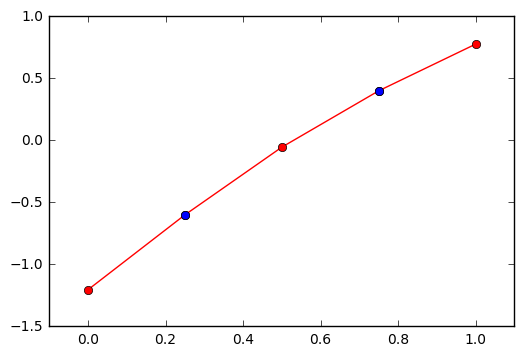

In [168]:
# calculate conditional mean from the above formula
def conditional_mean(x, x_new, y):
    k_X_new_X = cov_matrix(x_new, x)
    k_X_X_inv = np.linalg.inv(cov_matrix(x, x))
    mean = np.matmul(np.matmul(k_X_new_X, k_X_X_inv), y)
    return mean
    
# calcualte conditional matrix
def conditional_cov_matrix(x, x_new, y):
    k_X_new_X_new = cov_matrix(x_new, x_new)
    k_X_X_inv = np.linalg.inv(cov_matrix(x, x))
    k_X_new_X = cov_matrix(x_new, x)
    k_X_X_new = cov_matrix(x, x_new)
    cov = k_X_new_X_new - np.matmul(np.matmul(k_X_new_X, k_X_X_inv), k_X_X_new)
    return cov

def conditional_GP(x, x_new, y):
    mean = conditional_mean(x, x_new, y)
    cov = conditional_cov_matrix(x, x_new, y)
    y_new = multivariate_normal.rvs(mean = mean, cov = cov)
    return y_new

# include location of observed data points
x_new = np.linspace(0, 1, 5)

# sample conditional GP
y_new = conditional_GP(x, x_new, y)

plt.plot(x_new, y_new, '-ro')
plt.plot(x, y, 'o')
plt.xlim(-.1, 1.1)

One really cool thing is that sampling many functions from this conditional distribution allows us to calculate the uncertainty of points based on their variability from the sampled functions. Here, we can see that the most amount of uncertainty and variability occurs from parts of the function furthest from the observed points.

//anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


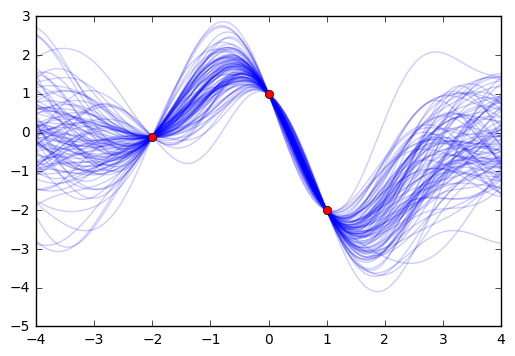

In [171]:
# observed points
x = np.array([-2, 0, 1])
y = np.array([-0.1, 1, -2])
x_new = np.linspace(-4, 4, 100)

# plot sampled functions conditioned on observed data points
for i in range(100):
    y_new = conditional_GP(x, x_new, y)
    plt.plot(x_new, y_new, '-b', alpha=0.2)

# plot observed data points
plt.plot(x, y, 'ro')    